# Import Modules

In [1]:
# モジュールをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import openpyxl
import xlsxwriter
import datetime
import warnings
from importlib import reload

import Predict

# pandasの行と列の最大出力数を指定
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 1000)

# 警告を非表示
warnings.filterwarnings('ignore')

# Preprocessing

## Read File

In [2]:
# Excelファイルの読み出し
file_name = '/Users/shohei/Desktop/Shohei/Fresnel/Formation/Data/dataset_new.xlsx'
sheet_name = '2019-01-30'
excel_book = pd.ExcelFile(file_name)
df_old = excel_book.parse(sheet_name)

## Select Columns

In [3]:
# 必要なカラムを抽出
cols = ['star', 'planet', 'Fe/H_sweet', 'Fe/H_casa', 'dFe/H_sweet', 'Ms_sweet', 'Ms_padova', 'dMs_sweet']
df = df_old[cols]

In [4]:
# インデックスに'star'と'planet'を指定
df = df.set_index(['star', 'planet'])

## Check Null Data

In [5]:
# 各カラムのNullの個数を表示
df.isnull().sum()

Fe/H_sweet      62
Fe/H_casa      346
dFe/H_sweet     66
Ms_sweet        68
Ms_padova      350
dMs_sweet       63
dtype: int64

# Correlation Diagram

<Figure size 720x720 with 0 Axes>

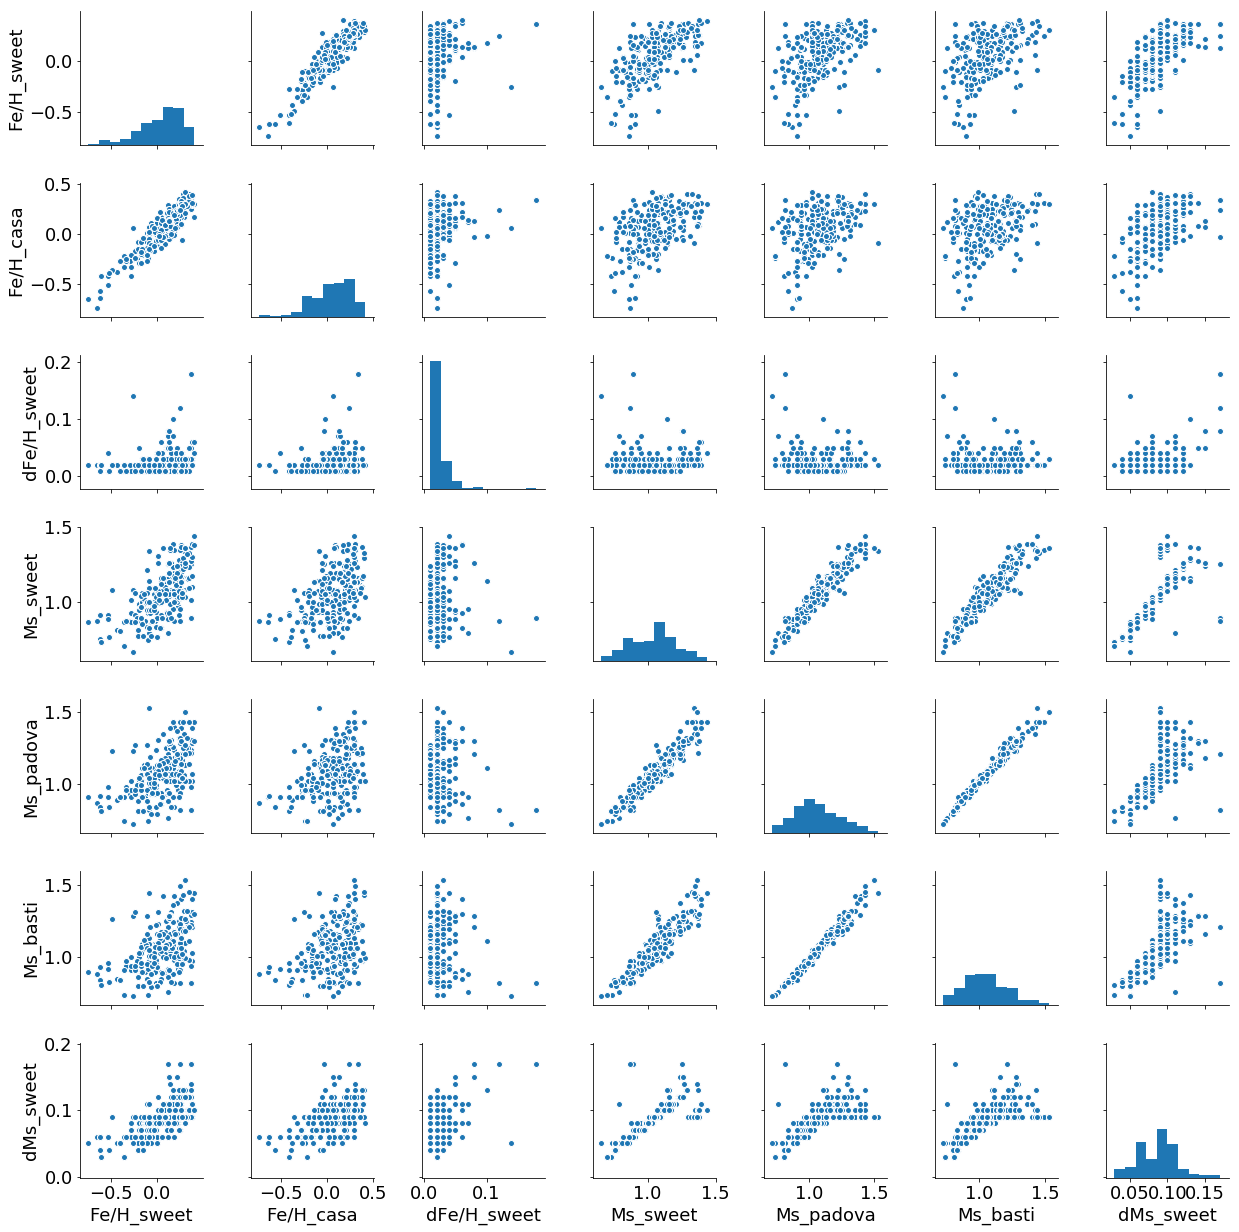

In [150]:
# 各カラムの相関図を作成
plt.figure(figsize=(10, 10))
plt.rcParams['font.size'] = 18
sns.pairplot(df.dropna())
plt.show()

# Predicting

## Predict Value

### Reload

In [6]:
# Predictをリロードし、再インポート
reload(Predict)
from Predict import Value as val

### Devide Data

In [7]:
# それぞれのDFを作成
metal_raw = df[['Fe/H_sweet', 'Fe/H_casa']]
Ms_raw = df[['Ms_sweet', 'Ms_padova']]

### Evaluate Model

In [8]:
# RMSEでモデルを評価
print('[RMSE]')
print(' Fe/H:', val(metal_raw, sweet='Fe/H_sweet', other='Fe/H_casa').evaluate())
print('   Ms:', val(Ms_raw, sweet='Ms_sweet', other='Ms_padova').evaluate())

[RMSE]
 Fe/H: 0.07596352558768688
   Ms: 0.059069879486496085


### Extract Predicted Data

In [9]:
# モデルで作成した予測データを元にDFを作成
metal_val_pred = val(metal_raw, sweet='Fe/H_sweet', other='Fe/H_casa').main('Fe/H')
Ms_val_pred = val(Ms_raw, sweet='Ms_sweet', other='Ms_padova').main('Ms')

### Merge DataFrame

In [10]:
# 予測データを一つのDFに合体
df_val = df.merge(metal_val_pred, how='left', left_index=True, right_index=True)
df_val = df_val.merge(Ms_val_pred, how='left', left_index=True, right_index=True)

### Number of added data

In [11]:
# 追加されたデータの個数を表示
add_metal = df_val['Fe/H_sweet'].isnull().sum()-df_val['Fe/H'].isnull().sum()
add_Ms = df_val['Ms_sweet'].isnull().sum()-df_val['Ms'].isnull().sum()
print(f'Fe/H: {add_metal} samples')
print(f'  Ms: {add_Ms} samples')

Fe/H: 37 samples
  Ms: 38 samples


### Number of Null data

In [12]:
# 最終的に欠損しているデータの個数を表示
null_metal = df_val['Fe/H'].isnull().sum()
null_Ms = df_val['Ms'].isnull().sum()
print(f'Fe/H: {null_metal} samples')
print(f'  Ms: {null_Ms} samples')

Fe/H: 25 samples
  Ms: 30 samples


## Predict Variance

### Reload

In [13]:
# Predictをリロードし、再インポート
reload(Predict)
from Predict import Variance as var

### Scatter Plot

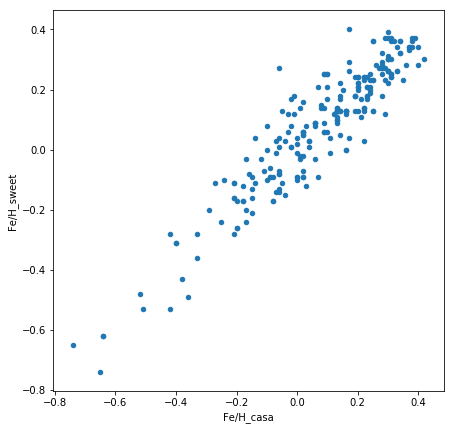

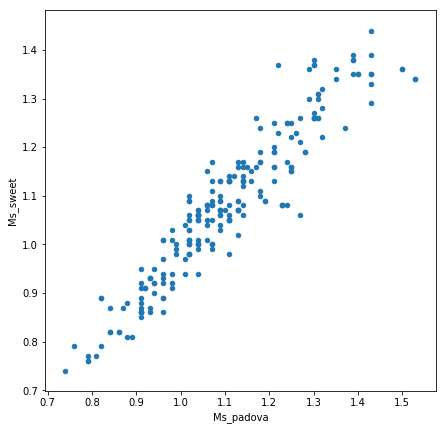

In [14]:
# 各パラメーターの散布図を表示
df_val.plot(kind='scatter', x='Fe/H_casa', y='Fe/H_sweet', figsize=(7, 7))
df_val.plot(kind='scatter', x='Ms_padova', y='Ms_sweet', figsize=(7, 7))

### Extract Variance

In [15]:
# PCAの第２主成分方向の分散を予測データの誤差として採用
metal_var_pred = var(df, sweet='Fe/H_sweet', other=['Fe/H_casa'], dsweet='dFe/H_sweet').main('dFe/H')
Ms_var_pred = var(df, sweet='Ms_sweet', other=['Ms_padova'], dsweet='dMs_sweet').main('dMs')

### Merge DataFrame

In [16]:
# 誤差データを含んだDFを作成
df_var = df_val.merge(metal_var_pred, how='left', left_index=True, right_index=True)
df_var = df_var.merge(Ms_var_pred, how='left', left_index=True, right_index=True)

# Save Data

In [273]:
# 予測データを古いDFに追加
df_add = df_var[['Fe/H', 'Ms', 'dFe/H', 'dMs']]
df_new = df_old.set_index(['star', 'planet']).merge(df_add, how='left', left_index=True, right_index=True).reset_index()

In [276]:
# 新しいDFをExcelファイルの新たなsheetに追加
today = datetime.date.today().isoformat()
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    writer.book = openpyxl.load_workbook(file_name)
    df_new.to_excel(writer, sheet_name=f'{today}', index=False)